<a href="https://colab.research.google.com/github/yandexdataschool/MLatImperial2020/blob/master/06_lab/Solution_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Recap

Today we'll play around with convolutional neural networks, but before we do that let's start from where we left off yesterday.

The cells below contain some code that we came up with in the yesterday's notebook.

Some imports:

In [1]:
from torchvision.datasets import FashionMNIST
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
print(torch.__version__)
from IPython.display import clear_output

1.4.0


A utility class to monitor the training procedure:

In [0]:
from IPython.display import clear_output

class Logger:
  def __init__(self):
    self.train_loss_batch = []
    self.train_loss_epoch = []
    self.test_loss_batch = []
    self.test_loss_epoch = []
    self.train_batches_per_epoch = 0
    self.test_batches_per_epoch = 0
    self.epoch_counter = 0

  def fill_train(self, loss):
    self.train_loss_batch.append(loss)
    self.train_batches_per_epoch += 1

  def fill_test(self, loss):
    self.test_loss_batch.append(loss)
    self.test_batches_per_epoch += 1

  def finish_epoch(self):
    self.train_loss_epoch.append(np.mean(
        self.train_loss_batch[-self.train_batches_per_epoch:]
    ))
    self.test_loss_epoch.append(np.mean(
        self.test_loss_batch[-self.test_batches_per_epoch:]
    ))
    self.train_batches_per_epoch = 0
    self.test_batches_per_epoch = 0
    
    clear_output()
  
    print("epoch #{} \t train_loss: {:.8} \t test_loss: {:.8}".format(
              self.epoch_counter,
              self.train_loss_epoch[-1],
              self.test_loss_epoch [-1]
          ))
    
    self.epoch_counter += 1

    plt.figure(figsize=(11, 5))

    plt.subplot(1, 2, 1)
    plt.plot(self.train_loss_batch, label='train loss')
    plt.xlabel('# batch iteration')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(self.train_loss_epoch, label='average train loss')
    plt.plot(self.test_loss_epoch , label='average test loss' )
    plt.legend()
    plt.xlabel('# epoch')
    plt.ylabel('loss')
    plt.show();

Data preprocessing:

In [0]:
def preprocess_data(X, y):
  X_preprocessed = torch.tensor(X / 255.,
                                dtype=torch.float).reshape(-1, 28 * 28)
  y_preprocessed = torch.tensor(y)
  return X_preprocessed.cuda(), y_preprocessed.cuda()

Batch generator:

In [0]:
# Batch generator
# (here's a very brief description of what python generators are:
# https://stackoverflow.com/a/231855/3801744)
def get_batches(X, y, batch_size, shuffle=False):
  if shuffle:
    shuffle_ids = np.random.permutation(len(X))
    X = X[shuffle_ids].copy()
    y = y[shuffle_ids].copy()
  for i_picture in range(0, len(X), batch_size):
    # Get batch and preprocess it:
    batch_X = X[i_picture:i_picture + batch_size]
    batch_y = y[i_picture:i_picture + batch_size]
    
    # 'return' the batch (see the link above to
    # better understand what 'yield' does)
    yield preprocess_data(batch_X, batch_y)

Getting the data:

In [5]:
# Getting the train and test parts of the dataset
data_train = FashionMNIST("FashionMNIST/",
                          download=True,
                          train=True)

data_test = FashionMNIST("FashionMNIST/",
                          download=True,
                          train=False)

# In fact, it's already stored as torch tensor, but we'll need
# to work with the numpy representation, so let's do the convertion:
X_train = data_train.train_data.numpy()
y_train = data_train.train_labels.numpy()

X_test = data_test.test_data.numpy()
y_test = data_test.test_labels.numpy()


Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Getting predictions on the test data:

In [0]:
from sklearn.metrics import accuracy_score

def get_test_predictions(model, batch_size=100):
  predictions_test = np.concatenate([
    model(batch_X).to('cpu').detach().numpy()
    for batch_X, batch_y in get_batches(X_test, y_test, batch_size)
  ], axis=0)
  return np.argmax(predictions_test, axis=1)

And finally, the training procedure (we've put it into a function to re-use with different models):

In [0]:
def fit(model, loss_function, optimizer, num_epochs, batch_size):
  logger = Logger()

  for i_epoch in range(num_epochs):
    model.train() # setting the model to training mode
    for batch_X, batch_y in get_batches(X_train, y_train,
                                        batch_size=batch_size, shuffle=True):
      predictions = model(batch_X) # compute the predictions
      loss = loss_function(predictions, batch_y) # compute the loss
      logger.fill_train(loss.item())

      model.zero_grad() # zero the gradients
      loss.backward() # compute new gradients
      optimizer.step() # do an optimization step

    # Now, let's evaluate on the test part:
    model.eval() # setting the model to evaluatioin mode
    for batch_X, batch_y in get_batches(X_test, y_test,
                                        batch_size=batch_size):
      loss = loss_function(model(batch_X), batch_y)
      logger.fill_test(loss.item())
    
    logger.finish_epoch()
  
  # Counting model parameters
  n_parameters = 0
  for parameter in model.parameters():
    n_parameters += parameter.reshape(-1).shape[0]

  print("# of trainable parameters:", n_parameters)

  model.eval()
  print("Model accuracy:", accuracy_score(y_test, get_test_predictions(model)))

#### Yesterday's model

epoch #19 	 train_loss: 0.27622822 	 test_loss: 0.35409675


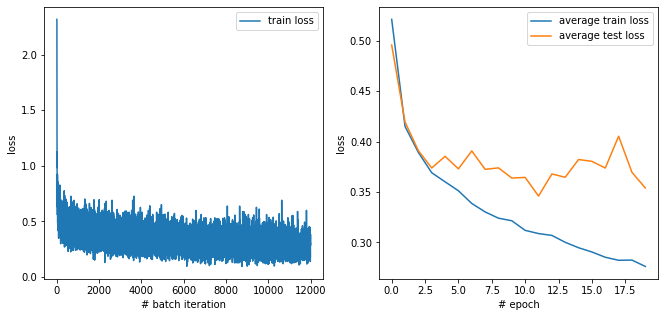

# of trainable parameters: 79510
Model accuracy: 0.8837


In [8]:
# Defining the loss function:
loss_function = torch.nn.CrossEntropyLoss()

# Defining the model
input_size = 28 * 28 # number of pixels per image
output_size = 10 # number of classes
n_hidden = 100

device = torch.device('cuda')

model = torch.nn.Sequential(
    torch.nn.Linear(in_features=input_size,
                    out_features=n_hidden),
    torch.nn.ELU(),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(in_features=n_hidden,
                    out_features=output_size),
).to(device)

# Setting up the optimizer
learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

fit(model, loss_function, optimizer, num_epochs=20, batch_size=100)

### Convolutional layers

<img src='https://cdn-images-1.medium.com/max/1600/0*iqNdZWyNeCr5tCkc.' alt='CNN animation'>

One filter is applied to all the channels of the input image image, i.e.:
$$
V(x,y,t) = \sum_{i=x - \delta}^{x + \delta} \sum_{j=y - \delta}^{y + \delta} \sum_{s=1}^S K^t(i - x + \delta, j - y + \delta, s) \cdot U(i,j,s)
$$


the output value V in position x, y and channel t will be calculated by the formula above. U is the input image, K is the kernel 

<font color='red'>Question:</font>What will be the output size of the:

- picture of size 1x3x3, applied conv filter 3x3, stride=1, padding=0
- picture of size 1x10x10, applied conv filter 3x3, stride=1, padding=0
- picture of size 1x10x10, applied conv filter 3x3, stride=1, padding=1

- picture of size 3x20x20, applied conv filter 3x3, stride=3, padding=0


Eventually, this is the formula to calculate output size
$$
Output_{size} = \frac{(W−K+2P)}{S}+1
$$

W is the input size (H or W)
K is the Kernel size
P is the padding
S is the stride

<img src='https://cdn-images-1.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg' alt='img'>
(image taken from https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

A general view of the most common convolutional architecture is shown above. The main idea is to gradually reduce the size of the image while increasing the number of channels. This is motivated by the following:

 - It's expensive (in terms of memory) to make a lot of channels for a large image, while smaller sized images allow us to do so. Intuitively, there's a trade-off between image size and number of channels.
 - We actually don't need that many channels at lower levels since there's not that many distinct low-level features for an image. Higher level features are more complex and require more filters (channels).
 - At the left side of the diagram (for low-level features) we care more about the positional information (e.g. "is this stroke located near that one?"), while at the right side (high-level features) we want to know what kind of an object we see, rather than where exactly we see it (e.g. "looks like there's furry face somewhere in this picture - I might be looking at a cat")

#### Getting a grip on convolutions

Let's get an image of a cat:

In [9]:
!wget https://github.com/yandexdataschool/MLatImperial2020/raw/master/06_lab/cat.jpg

--2020-02-04 13:34:44--  https://github.com/yandexdataschool/MLatImperial2020/raw/master/06_lab/cat.jpg
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yandexdataschool/MLatImperial2020/master/06_lab/cat.jpg [following]
--2020-02-04 13:34:44--  https://raw.githubusercontent.com/yandexdataschool/MLatImperial2020/master/06_lab/cat.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54350 (53K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  53.08K  --.-KB/s    in 0.008s  

2020-02-04 13:34:44 (6.61 MB/s) - ‘cat.jpg’ saved [54350/54350]



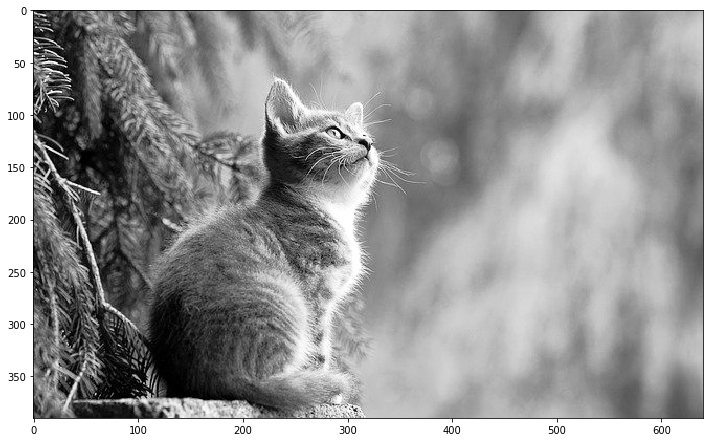

In [10]:
from matplotlib.pyplot import imread
from skimage import color


img = color.rgb2grey(imread('cat.jpg')).astype(np.float32)

plt.figure(figsize=(12, 8))
plt.imshow(img, cmap='Greys_r');

Now convolve this image with a single 3x3 filter and check out the result:

torch.Size([1, 1, 3, 3])


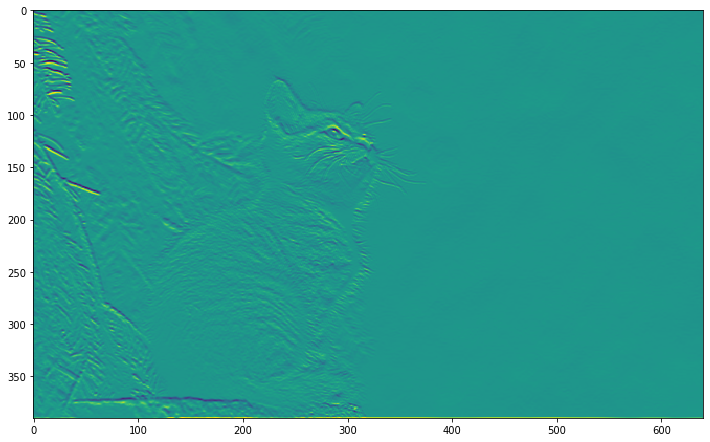

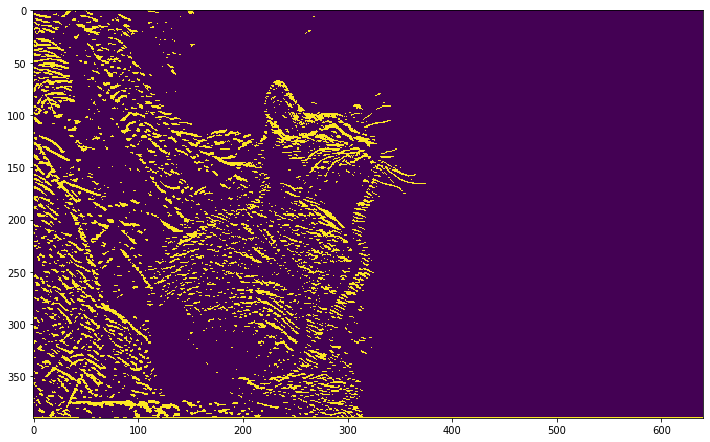

In [12]:
kernel = torch.Tensor([[1., 1., 1.],
                       [0., 0., 0.],
                       [-1., -1., -1.]])[None, None,:]
print(kernel.shape)

convolved_image = torch.nn.functional.conv2d(
    torch.tensor(img).unsqueeze(0).unsqueeze(0),
    kernel,
    stride=1,
    padding=1
)
                              # Use torch.nn.functional.conv2d.
                              # Don't forget to convert torch tensor
                              # to a numpy array afterwards.

convolved_image = convolved_image.numpy().squeeze()

plt.figure(figsize=(12, 8))
plt.imshow(convolved_image);
plt.figure(figsize=(12, 8))
plt.imshow(convolved_image > 0.2);

Once you're done try other kernels and see how they affect the image – what features do they highlight?

Some suggestions:
```
[[ 0., -1.,  0.],
 [-1.,  4., -1.],
 [ 0., -1.,  0.]]
```

```
[[-2., -1.,  0.],
 [-1.,  0.,  1.],
 [ 0.,  1.,  2.]]
```

What will happen if you apply a convolution twice? `n` times?

#### Building a CNN

In [19]:
mp_input = torch.arange(0, 49, dtype=float).view(1, 1, 7, 7)

mp_output = torch.nn.MaxPool2d(2, padding=0)(mp_input)

print(mp_input)
print('---')
print(mp_output)

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.],
          [ 7.,  8.,  9., 10., 11., 12., 13.],
          [14., 15., 16., 17., 18., 19., 20.],
          [21., 22., 23., 24., 25., 26., 27.],
          [28., 29., 30., 31., 32., 33., 34.],
          [35., 36., 37., 38., 39., 40., 41.],
          [42., 43., 44., 45., 46., 47., 48.]]]], dtype=torch.float64)
---
tensor([[[[ 8., 10., 12.],
          [22., 24., 26.],
          [36., 38., 40.]]]], dtype=torch.float64)


Convolutional layers in torch expect their input to be of 4-dimensional shape: $(B, C, H, W)$. Here $B$ is the number images per batch, $C$ is the number of channels (e.g. 1 for a greyscale image, 3 for an RGB one, or number of filters from the previous convolutional layer). $H$ and $W$ are height and width in pixels.

This means, at the beggining of our network we need to reshape our images from $(B, 784)$ to $(B, 1, 28, 28)$. In the end we'll want to reshape it back to 2 dimensions in order to apply a linear connection.

For some reason torch doesn't have a reshaping layer, so we'll implement our own:

In [0]:
class Reshape(torch.nn.Module):
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.reshape(x.shape[0], *self.shape)

Ok, now let's create and train a convolutional NN!

Do keep in mind the model architecture from the picture above. I.e. we want to gradually reduce the size of the image while increasing the number of channels. We also want at least one fully connected layer at the end of the network.

Use `torch.nn.Conv2d` for convolutions and `torch.nn.MaxPool2d` for max pooling.

epoch #19 	 train_loss: 0.3157074 	 test_loss: 0.32267392


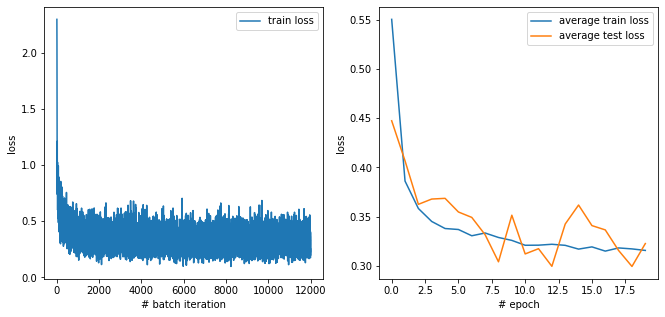

# of trainable parameters: 11018
Model accuracy: 0.8867


In [20]:
# Define the hyperparameters of our model:
learning_rate = 0.005
dropout_rate = 0.2

device = torch.device('cuda')

# Define the model itself
model = torch.nn.Sequential(
            Reshape(1, 28, 28),

            torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            torch.nn.ELU(),
            torch.nn.Dropout(p=dropout_rate),
            # (8, 28, 28)
            torch.nn.MaxPool2d(2),
            # (8, 14, 14)
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            torch.nn.ELU(),
            torch.nn.Dropout(p=dropout_rate),
            # (16, 14, 14)
            torch.nn.MaxPool2d(2),
            # (16, 7, 7)
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ELU(),
            torch.nn.Dropout(p=dropout_rate),
            # (32, 7, 7)
            torch.nn.MaxPool2d(2, padding=1),
            # (32, 4, 4)

            Reshape(512),
            torch.nn.Linear(512, 10)
        ).to(device)

# Creating the instances of the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

fit(model, loss_function, optimizer, num_epochs=20, batch_size=100)

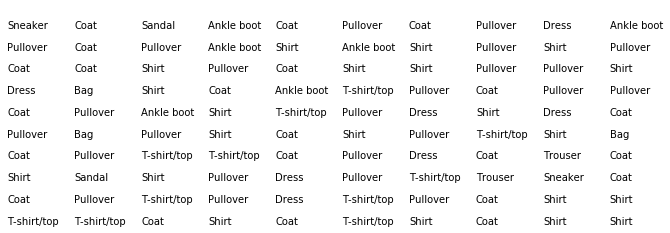

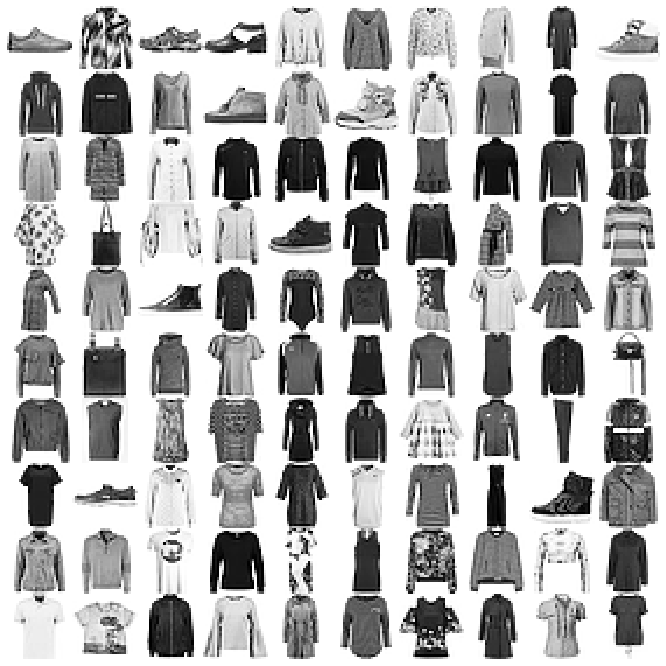

In [21]:
predictions_test = get_test_predictions(model)

wrongly_predicted = X_test[predictions_test != y_test]
wrongly_predicted_labels = y_test[predictions_test != y_test]

label_names = np.array([
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
])


# Print and plot the first 100:
wrongly_predicted_labels = \
  label_names[wrongly_predicted_labels[:100]].reshape(10, 10)

for ix in range(10):
  for iy in range(10):
    plt.text(ix / 5, iy / 10, (wrongly_predicted_labels[-1 - iy, ix]))
plt.axis('off')
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(wrongly_predicted[:100].reshape(10, 10, 28, 28)
           .transpose(0, 2, 1, 3).reshape(280, 280), cmap="Greys")
plt.axis('off');